# RATIO 2019 - Benchmarking Workshop

Gluon Data: https://gluon-nlp.mxnet.io/model_zoo/bert/index.html#bert-for-sentence-classification-on-glue-tasks

```
curl -L https://tinyurl.com/yaznh3os -o download_glue_data.py
```

https://gluon-nlp.mxnet.io/install.html

```
pip install --upgrade 'mxnet>=1.3.0'
pip install gluonnlp
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
unzip sentence_embedding.zip
```

https://pypi.org/project/pytorch-pretrained-bert/#installation

```
# nope
# pip install pytorch-pretrained-bert
```

In [28]:
import datetime
import logging
import os
import random
import time
import warnings


import numpy as np
import mxnet as mx
from mxnet import gluon
import gluonnlp as nlp
from bert import *

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn import utils

from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [4]:
# apply progress bars for pandas .apply() -> .progress_apply()
tqdm.pandas()

In [5]:
class Timer:
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.time_start = time.time()

    def __exit__(self, *exc):
        time_end = time.time()
        time_delta = datetime.timedelta(seconds=(time_end - self.time_start))
        if self.name:
            print(("Time for [{}]: {}".format(self.name, time_delta)))
        else:
            print(("Time: {}".format(time_delta)))

# Task 1 - Same Side Classification

In [6]:
data_cross_path = 'data/same-side-classification/cross-topic/{}.csv'
data_within_path = 'data/same-side-classification/within-topic/{}.csv'

In [7]:
%%bash
head -n 5 data/same-side-classification/cross-topic/training.csv

"id","argument1","argument1_id","argument2","argument2_id","debate_id","is_same_side","topic"
"0","there are two reasons why this debate should go to the con side. reason 1: my opponent agrees with me in his last round, my opponent states that the \"number one reason does have to [do with] financial reasons.\" he cites that 42% of women who had abortions could not afford a child and were unmarried, which means the total proportion of women who had abortions that could not afford a child is likely to be at least 50% (if you factor in women who could not afford a child and were married). 38% of women who had abortions said that children would interfere with their education, and 38% of said that children would interfere with their employment. again, even assuming 50% overlap (an unrealistically high overlap) between the two groups, the proportion of women aborting due to career considerations is still over half. my opponent says that abortion should be illegal with exceptions. is the stat

### Load within-topics and cross-topics data

In [8]:
# escapechar to detect quoting escapes, else it fails

# na_filter=False, because pandas automatic "nan" detection fails with the topic column, too
# cross_test_df['topic'].astype(str)[9270]

with Timer("read cross"):
    cross_traindev_df = pd.read_csv(data_cross_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    cross_test_df = pd.read_csv(data_cross_path.format('test'), index_col='id', escapechar='\\', na_filter=False)

with Timer("read within"):
    within_traindev_df = pd.read_csv(data_within_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    within_test_df = pd.read_csv(data_within_path.format('test'), index_col='id', escapechar='\\', na_filter=False)

Time for [read cross]: 0:00:00.907910
Time for [read within]: 0:00:00.952161


In [10]:
# Adding a tag for the topics in focus: "gay marriage" and "abortion"
def add_tag(row):
    title = row['topic'].lower().strip()
    if "abortion" in title:
        row['tag'] = 'abortion'
    elif "gay marriage"  in title:
        row['tag'] = 'gay marriage'
    else:
        row['tag'] = 'NA'
    return row


with Timer("tag cross traindev"):
    cross_traindev_df = cross_traindev_df.apply(add_tag, axis=1)
with Timer("tag cross test"):
    cross_test_df = cross_test_df.apply(add_tag, axis=1)

with Timer("tag within traindev"):
    within_traindev_df = within_traindev_df.apply(add_tag, axis=1)
with Timer("tag within test"):
    within_test_df = within_test_df.apply(add_tag, axis=1)

Time for [tag cross traindev]: 0:00:31.674695
Time for [tag cross test]: 0:00:17.682249
Time for [tag within traindev]: 0:00:32.847750
Time for [tag within test]: 0:00:16.422105


### Get an overview about each dataset

In [11]:
def get_overview(df, task='same-side', class_name='is_same_side'):
    # Total instance numbers
    total = len(df)
    print("Task: ", task)
    print('=' * 40, '\n')

    print('Total instances: ', total)
    print('\n')

    print('For each topic:')
    for tag, tag_df in df.groupby(['tag']):
        print(tag, ': ', len(tag_df), ' instances')
        if class_name in df.columns:
            for is_same_side, side_df in tag_df.groupby([class_name]):
                print('\t\t', is_same_side, ': ', len(side_df), ' instances')
    print('\n')

    if class_name in df.columns:
        print('For each class value:')
        for class_value, class_df in df.groupby([class_name]):
            print(class_value, ': ', len(class_df), ' instances')
        print('\n')

    print('Unique argument1:', len(df['argument1'].unique()))
    print('Unique argument2:', len(df['argument2'].unique()))
    arguments = df['argument1'].values
    arguments = np.concatenate([arguments, df['argument2'].values])

    print('Unique total arguments:', len(set(list(arguments))), '\n')

    print('-' * 40, '\n')

    arguments_length_lst = [
        len(word_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_length_lst.extend(
        [len(word_tokenize(x)) for x in df['argument2'].values])
    print('Words:')
    print('\tshortest argument:', min(arguments_length_lst), ' words')
    print('\tlongest argument:', max(arguments_length_lst), ' words')
    print('\targument average length:', np.mean(arguments_length_lst),
          ' words')

    arguments_sent_length_lst = [
        len(sent_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_sent_length_lst.extend(
        [len(sent_tokenize(x)) for x in df['argument2'].values])
    print('Sentences:')
    print('\tshortest argument:', min(arguments_sent_length_lst), ' sentences')
    print('\tlongest argument:', max(arguments_sent_length_lst), ' sentences')
    print('\targument average length:', np.mean(arguments_sent_length_lst),
          ' sentences')

In [12]:
# with Timer("overview cross"):
#     get_overview(cross_traindev_df)

In [13]:
# with Timer("overview within"):
#     get_overview(within_traindev_df)

## Train model - Baseline

### train dev set - 70% 30%

In [14]:
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic']]
    y = df[['is_same_side']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

### BERT

- https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html

In [16]:
from mxnet.gluon.data import SimpleDataset

class MyBERTDataset(SimpleDataset):
    def __init__(self, X, y=None):
        self._X = X
        self._y = y
        super(MyBERTDataset, self).__init__(self._convert())

    # def _convert(self):
    #     allsamples = list()
    #     for _, row in self._X[['argument1', 'argument2', 'is_same_side']].iterrows():
    #         allsamples.append([row['argument1'], row['argument2'], "1" if row['is_same_side'] else "0"])
    #     return allsamples
    
    def _convert(self):
        allsamples = list()

        if self._y is not None:
            df = self._X.merge(self._y, left_index=True, right_index=True)
            for _, row in df.iterrows():
                allsamples.append([row['argument1'], row['argument2'], "1" if row['is_same_side'] == "True" else "0"])
        else:
            for _, row in self._X.iterrows():
                allsamples.append([row['argument1'], row['argument2'], None])
        
        return allsamples

    # def __getitem__(self, idx):
    #     row_X = self._X.iloc[idx]
    #     row_y = self._y.iloc[idx]
    #     return [row_X['argument1'], row_X['argument2'], "1" if row_y['is_same_side'] else "0"]

    # def __len__(self):
    #     return len(self._X)

In [17]:
# df = X_dev.merge(y_dev, left_index=True, right_index=True)
# allsamples = list()
# for _, row in df.iterrows():
#     allsamples.append("1" if row['is_same_side'] == "True" else "0")
# np.unique(allsamples)

In [36]:
def setup_bert():
    np.random.seed(100)
    random.seed(100)
    mx.random.seed(10000)
    # change `ctx` to `mx.cpu()` if no GPU is available.
    ctx = mx.gpu(0)
    # ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
    # ctx = mx.cpu()
    
    bert_base, vocabulary = nlp.model.get_model('bert_12_768_12',
                                                 dataset_name='book_corpus_wiki_en_uncased',
                                                 pretrained=True, ctx=ctx, use_pooler=True,
                                                 use_decoder=False, use_classifier=False)
    print(bert_base)
    
    model = bert.BERTClassifier(bert_base, num_classes=2, dropout=0.1)
    # only need to initialize the classifier layer.
    model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.hybridize(static_alloc=True)

    # softmax cross entropy loss for classification
    loss_function = gluon.loss.SoftmaxCELoss()
    loss_function.hybridize(static_alloc=True)

    metric = mx.metric.Accuracy()
    
    # use the vocabulary from pre-trained model for tokenization
    bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
    # maximum sequence length
    max_len = 128
    # the labels for the two classes
    all_labels = ["0", "1"]
    # whether to transform the data as sentence pairs.
    # for single sentence classification, set pair=False
    pair = True
    transform = dataset.BERTDatasetTransform(bert_tokenizer, max_len,
                                             labels=all_labels,
                                             label_dtype='int32',
                                             pad=True,
                                             pair=pair)

    return model, vocabulary, ctx, transform, loss_function, metric, all_labels

    
def transform_dataset(X, y, transform):
    data_train_raw = MyBERTDataset(X, y)
    data_train = data_train_raw.transform(transform)
    return data_train_raw, data_train


def print_infos(vocabulary, data_train_raw, data_train):
    sample_id = 0

    # sentence a
    print(data_train_raw[sample_id][0])
    # sentence b
    print(data_train_raw[sample_id][1])
    # 1 means equivalent, 0 means not equivalent
    print(data_train_raw[sample_id][2])

    print('vocabulary used for tokenization = \n%s'%vocabulary)
    print('[PAD] token id = %s'%(vocabulary['[PAD]']))
    print('[CLS] token id = %s'%(vocabulary['[CLS]']))
    print('[SEP] token id = %s'%(vocabulary['[SEP]']))

    print('token ids = \n%s'%data_train[sample_id][0])
    print('valid length = \n%s'%data_train[sample_id][1])
    print('segment ids = \n%s'%data_train[sample_id][2])
    print('label = \n%s'%data_train[sample_id][3])
    

def train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(), 'adam', {
            'learning_rate': lr,
            'epsilon': 1e-9
        })

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [p for p in model.collect_params().values() if p.grad_req != 'null']

    log_interval = 10
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            epoch_checkpoint_savefile = "data/bert.model.checkpoint{}.params".format(epoch_id)
            if os.path.exists(epoch_checkpoint_savefile):
                model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                print("loaded checkpoint for epoch {}".format(epoch_id))
                continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               label) in enumerate(bert_dataloader):
                    with mx.autograd.record():

                        # load data to GPU
                        token_ids = token_ids.as_in_context(ctx)
                        valid_length = valid_length.as_in_context(ctx)
                        segment_ids = segment_ids.as_in_context(ctx)
                        label = label.as_in_context(ctx)

                        # forward computation
                        out = model(token_ids, segment_ids,
                                    valid_length.astype('float32'))
                        ls = loss_function(out, label).mean()

                    # backward computation
                    ls.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    step_loss += ls.asscalar()
                    metric.update([label], [out])
                    stats.append((metric.get()[1], ls.asscalar()))
                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(epoch_id, batch_id + 1, len(bert_dataloader),
                                    step_loss / log_interval, trainer.learning_rate,
                                    metric.get()[1],
                                    datetime.timedelta(seconds=(time.time() - t_p))))
                        t_p = time.time()
                        step_loss = 0

            model.save_parameters(epoch_checkpoint_savefile)
            
    return stats


def predict(model, data_predict, ctx, metric, loss_function, batch_size=32):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict, batch_size=batch_size)
    
    all_predictions = list()

    with Timer("prediction"):
        metric.reset()
        cum_loss = 0
        for batch_id, (token_ids, valid_length, segment_ids,
                       label) in enumerate(tqdm(bert_dataloader)):
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            label = label.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids,
                        valid_length.astype('float32'))
            ls = loss_function(out, label).mean()

            metric.update([label], [out])
            cum_loss += ls.asscalar()  # .sum() ?
            all_predictions.append((batch_id, label, out))
            
    return all_predictions, cum_loss


def predict_out_to_ys(all_predictions, all_labels):
    y_true, y_pred = list(), list()
    
    for _, y_true_many, y_pred_many in all_predictions:
        y_true_many = y_true_many.T[0].asnumpy()
        # https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss
        # pred: the prediction tensor, where the batch_axis dimension ranges over batch size and axis dimension ranges over the number of classes.
        y_pred_many = np.argmax(y_pred_many, axis=1).asnumpy()

        y_true.extend(list(y_true_many))
        y_pred.extend(list(y_pred_many))
        # TODO: convert label_id to label?
        # y_pred.extend(all_labels[c] for c in list(y_pred_many))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    return y_true, y_pred


def plot_train_stats(stats):
    x = np.arange(len(stats))  # arange/linspace

    acc_dots, loss_dots = zip(*stats)

    plt.subplot(2, 1, 1)
    plt.plot(x, acc_dots, 'o-')
    plt.title('Training BERTClassifier')
    plt.ylabel('Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_dots, '.-')
    plt.xlabel('Batches')
    plt.ylabel('Loss')

    plt.show()

### Train run

In [20]:
X_train, X_dev, y_train, y_dev = get_train_test_sets(within_traindev_df)

In [21]:
model, vocabulary, ctx, transform, loss_function, metric, all_labels = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [22]:
data_train_raw, data_train = transform_dataset(X_train, y_train, transform)

In [23]:
print_infos(vocabulary, data_train_raw, data_train)

wanted fetuses are beloved "babies"; unwanted ones are "tissue" (inconsistent)
abortions are emotionally and psychologically unsafe.
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  2359 10768  5809  2229  2024 11419  1000 10834  1000  1025 18162
  3924  2024  1000  8153  1000  1006 20316  1007     3 11324  2015  2024
 14868  1998  8317  2135 25135  1012     3     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1   

In [24]:
# train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)

100%|██████████| 44732/44732 [03:05<00:00, 241.79it/s]


Time for [setup training]: 0:03:05.021717
[Epoch 0 Batch 10/1401] loss=0.7123, lr=0.0000050, acc=0.463 - time 0:00:08.429463
[Epoch 0 Batch 20/1401] loss=0.7044, lr=0.0000050, acc=0.472 - time 0:00:07.867646
[Epoch 0 Batch 30/1401] loss=0.6946, lr=0.0000050, acc=0.492 - time 0:00:07.527696
[Epoch 0 Batch 40/1401] loss=0.7027, lr=0.0000050, acc=0.491 - time 0:00:07.696269
[Epoch 0 Batch 50/1401] loss=0.7174, lr=0.0000050, acc=0.485 - time 0:00:08.085456
[Epoch 0 Batch 60/1401] loss=0.7049, lr=0.0000050, acc=0.486 - time 0:00:07.885655
[Epoch 0 Batch 70/1401] loss=0.6898, lr=0.0000050, acc=0.489 - time 0:00:07.797247
[Epoch 0 Batch 80/1401] loss=0.6801, lr=0.0000050, acc=0.498 - time 0:00:08.268242
[Epoch 0 Batch 90/1401] loss=0.6777, lr=0.0000050, acc=0.507 - time 0:00:07.477864
[Epoch 0 Batch 100/1401] loss=0.6774, lr=0.0000050, acc=0.510 - time 0:00:08.402169
[Epoch 0 Batch 110/1401] loss=0.6804, lr=0.0000050, acc=0.512 - time 0:00:08.319002
[Epoch 0 Batch 120/1401] loss=0.6767, lr=0.

[Epoch 0 Batch 990/1401] loss=0.5263, lr=0.0000050, acc=0.659 - time 0:00:07.509619
[Epoch 0 Batch 1000/1401] loss=0.4658, lr=0.0000050, acc=0.660 - time 0:00:07.723069
[Epoch 0 Batch 1010/1401] loss=0.5230, lr=0.0000050, acc=0.660 - time 0:00:07.552863
[Epoch 0 Batch 1020/1401] loss=0.4819, lr=0.0000050, acc=0.661 - time 0:00:07.757634
[Epoch 0 Batch 1030/1401] loss=0.4789, lr=0.0000050, acc=0.662 - time 0:00:08.384501
[Epoch 0 Batch 1040/1401] loss=0.4649, lr=0.0000050, acc=0.663 - time 0:00:08.520907
[Epoch 0 Batch 1050/1401] loss=0.5330, lr=0.0000050, acc=0.663 - time 0:00:07.564851
[Epoch 0 Batch 1060/1401] loss=0.5286, lr=0.0000050, acc=0.664 - time 0:00:08.070094
[Epoch 0 Batch 1070/1401] loss=0.3950, lr=0.0000050, acc=0.665 - time 0:00:08.079727
[Epoch 0 Batch 1080/1401] loss=0.4627, lr=0.0000050, acc=0.666 - time 0:00:07.650658
[Epoch 0 Batch 1090/1401] loss=0.5199, lr=0.0000050, acc=0.666 - time 0:00:08.080456
[Epoch 0 Batch 1100/1401] loss=0.4338, lr=0.0000050, acc=0.667 - t

[Epoch 1 Batch 560/1401] loss=0.3879, lr=0.0000050, acc=0.771 - time 0:00:08.119269
[Epoch 1 Batch 570/1401] loss=0.3446, lr=0.0000050, acc=0.772 - time 0:00:08.166940
[Epoch 1 Batch 580/1401] loss=0.3895, lr=0.0000050, acc=0.772 - time 0:00:07.309890
[Epoch 1 Batch 590/1401] loss=0.2833, lr=0.0000050, acc=0.773 - time 0:00:08.045552
[Epoch 1 Batch 600/1401] loss=0.3271, lr=0.0000050, acc=0.774 - time 0:00:07.967530
[Epoch 1 Batch 610/1401] loss=0.3914, lr=0.0000050, acc=0.774 - time 0:00:08.316017
[Epoch 1 Batch 620/1401] loss=0.3145, lr=0.0000050, acc=0.775 - time 0:00:08.227765
[Epoch 1 Batch 630/1401] loss=0.3383, lr=0.0000050, acc=0.776 - time 0:00:07.850759
[Epoch 1 Batch 640/1401] loss=0.3849, lr=0.0000050, acc=0.776 - time 0:00:08.106729
[Epoch 1 Batch 650/1401] loss=0.3866, lr=0.0000050, acc=0.776 - time 0:00:08.476966
[Epoch 1 Batch 660/1401] loss=0.2966, lr=0.0000050, acc=0.777 - time 0:00:07.531598
[Epoch 1 Batch 670/1401] loss=0.3446, lr=0.0000050, acc=0.776 - time 0:00:07

[Epoch 2 Batch 130/1401] loss=0.2842, lr=0.0000050, acc=0.816 - time 0:00:08.021702
[Epoch 2 Batch 140/1401] loss=0.3099, lr=0.0000050, acc=0.817 - time 0:00:08.289311
[Epoch 2 Batch 150/1401] loss=0.3550, lr=0.0000050, acc=0.814 - time 0:00:08.560434
[Epoch 2 Batch 160/1401] loss=0.3104, lr=0.0000050, acc=0.815 - time 0:00:07.872391
[Epoch 2 Batch 170/1401] loss=0.2659, lr=0.0000050, acc=0.818 - time 0:00:07.831087
[Epoch 2 Batch 180/1401] loss=0.3006, lr=0.0000050, acc=0.819 - time 0:00:08.048283
[Epoch 2 Batch 190/1401] loss=0.2382, lr=0.0000050, acc=0.822 - time 0:00:07.812180
[Epoch 2 Batch 200/1401] loss=0.3389, lr=0.0000050, acc=0.821 - time 0:00:08.263330
[Epoch 2 Batch 210/1401] loss=0.2935, lr=0.0000050, acc=0.823 - time 0:00:07.919809
[Epoch 2 Batch 220/1401] loss=0.2225, lr=0.0000050, acc=0.826 - time 0:00:08.031448
[Epoch 2 Batch 230/1401] loss=0.3450, lr=0.0000050, acc=0.824 - time 0:00:08.306631
[Epoch 2 Batch 240/1401] loss=0.3455, lr=0.0000050, acc=0.823 - time 0:00:08

[Epoch 2 Batch 1110/1401] loss=0.2621, lr=0.0000050, acc=0.833 - time 0:00:08.081546
[Epoch 2 Batch 1120/1401] loss=0.1788, lr=0.0000050, acc=0.834 - time 0:00:07.604350
[Epoch 2 Batch 1130/1401] loss=0.2522, lr=0.0000050, acc=0.834 - time 0:00:07.765364
[Epoch 2 Batch 1140/1401] loss=0.2986, lr=0.0000050, acc=0.834 - time 0:00:08.241038
[Epoch 2 Batch 1150/1401] loss=0.2757, lr=0.0000050, acc=0.834 - time 0:00:07.989289
[Epoch 2 Batch 1160/1401] loss=0.3359, lr=0.0000050, acc=0.834 - time 0:00:08.209444
[Epoch 2 Batch 1170/1401] loss=0.2305, lr=0.0000050, acc=0.834 - time 0:00:07.994653
[Epoch 2 Batch 1180/1401] loss=0.2881, lr=0.0000050, acc=0.834 - time 0:00:08.298854
[Epoch 2 Batch 1190/1401] loss=0.3825, lr=0.0000050, acc=0.833 - time 0:00:08.636332
[Epoch 2 Batch 1200/1401] loss=0.2566, lr=0.0000050, acc=0.833 - time 0:00:07.830189
[Epoch 2 Batch 1210/1401] loss=0.2298, lr=0.0000050, acc=0.834 - time 0:00:07.570975
[Epoch 2 Batch 1220/1401] loss=0.2410, lr=0.0000050, acc=0.834 - 

In [25]:
model.save_parameters("data/bert.model.params")

In [30]:
# stats epoch 0
stats = [(0.463, 0.7123), (0.472, 0.7044), (0.492, 0.6946), (0.491, 0.7027), (0.485, 0.7174), (0.486, 0.7049), (0.489, 0.6898), (0.498, 0.6801), (0.507, 0.6777), (0.510, 0.6774), (0.512, 0.6804), (0.515, 0.6767), (0.521, 0.6557), (0.525, 0.6541), (0.529, 0.6627), (0.533, 0.6571), (0.538, 0.6374), (0.540, 0.6530), (0.542, 0.6601), (0.545, 0.6472), (0.548, 0.6380), (0.551, 0.6240), (0.554, 0.5918), (0.556, 0.6199), (0.557, 0.6604), (0.559, 0.6456), (0.561, 0.6307), (0.564, 0.5906), (0.566, 0.5811), (0.570, 0.5783), (0.570, 0.6558), (0.572, 0.6158), (0.575, 0.6104), (0.576, 0.6459), (0.578, 0.6042), (0.580, 0.6000), (0.580, 0.6210), (0.581, 0.5967), (0.584, 0.5439), (0.586, 0.5840), (0.588, 0.5868), (0.589, 0.5722), (0.592, 0.5480), (0.593, 0.5927), (0.595, 0.5637), (0.597, 0.5776), (0.598, 0.5984), (0.600, 0.5582), (0.601, 0.6020), (0.602, 0.5802), (0.603, 0.6227), (0.604, 0.5647), (0.606, 0.5723), (0.607, 0.5867), (0.608, 0.6026), (0.610, 0.5912), (0.611, 0.5460), (0.612, 0.5881), (0.614, 0.5492), (0.615, 0.5646), (0.616, 0.5599), (0.618, 0.5465), (0.619, 0.5451), (0.620, 0.5630), (0.622, 0.5262), (0.623, 0.5364), (0.624, 0.5776), (0.625, 0.5395), (0.625, 0.5752), (0.627, 0.5260), (0.628, 0.5089), (0.630, 0.4781), (0.632, 0.5075), (0.632, 0.5947), (0.634, 0.4587), (0.635, 0.4911), (0.637, 0.4553), (0.638, 0.4978), (0.639, 0.5615), (0.640, 0.5320), (0.641, 0.5166), (0.641, 0.5333), (0.642, 0.5349), (0.644, 0.4600), (0.646, 0.4905), (0.647, 0.4696), (0.649, 0.4941), (0.649, 0.5356), (0.650, 0.5460), (0.651, 0.4847), (0.651, 0.5764), (0.652, 0.4925), (0.653, 0.4920), (0.654, 0.5040), (0.655, 0.4575), (0.656, 0.4878), (0.657, 0.4863), (0.658, 0.4382), (0.659, 0.5263), (0.660, 0.4658), (0.660, 0.5230), (0.661, 0.4819), (0.662, 0.4789), (0.663, 0.4649), (0.663, 0.5330), (0.664, 0.5286), (0.665, 0.3950), (0.666, 0.4627), (0.666, 0.5199), (0.667, 0.4338), (0.668, 0.4790), (0.669, 0.3865), (0.670, 0.4556), (0.670, 0.4920), (0.671, 0.4475), (0.672, 0.4176), (0.673, 0.4944), (0.673, 0.4776), (0.673, 0.5621), (0.673, 0.4697), (0.675, 0.3726), (0.675, 0.4617), (0.676, 0.5107), (0.676, 0.4507), (0.677, 0.4423), (0.677, 0.4501), (0.678, 0.4360), (0.679, 0.4173), (0.680, 0.4354), (0.680, 0.4053), (0.681, 0.4539), (0.682, 0.4677), (0.682, 0.4357), (0.682, 0.5352), (0.683, 0.4342), (0.684, 0.3658), (0.684, 0.5012), (0.684, 0.4274), (0.685, 0.3888), (0.686, 0.4580)]
stats1 = [(0.762, 0.4022), (0.784, 0.3754), (0.757, 0.4910), (0.752, 0.4802), (0.745, 0.5064), (0.749, 0.4351), (0.761, 0.3358), (0.764, 0.4418), (0.770, 0.3495), (0.772, 0.3822), (0.777, 0.3288), (0.779, 0.3499), (0.777, 0.4608), (0.776, 0.4025), (0.773, 0.4587), (0.773, 0.3971), (0.771, 0.4782), (0.767, 0.5041), (0.768, 0.4014), (0.770, 0.3562), (0.771, 0.4098), (0.770, 0.4362), (0.771, 0.3615), (0.772, 0.3492), (0.773, 0.3819), (0.774, 0.3715), (0.772, 0.4625), (0.772, 0.3953), (0.772, 0.3972), (0.774, 0.3222), (0.772, 0.4583), (0.772, 0.4265), (0.772, 0.4151), (0.775, 0.2895), (0.773, 0.4737), (0.771, 0.4858), (0.771, 0.4258), (0.771, 0.3748), (0.771, 0.3944), (0.770, 0.4685), (0.770, 0.4081), (0.769, 0.4215), (0.769, 0.3755), (0.770, 0.3139), (0.772, 0.3441), (0.772, 0.4142), (0.772, 0.4515), (0.771, 0.3986), (0.771, 0.3995), (0.772, 0.3128), (0.773, 0.3351), (0.773, 0.3750), (0.773, 0.4671), (0.772, 0.4311), (0.771, 0.4054), (0.771, 0.3879), (0.772, 0.3446), (0.772, 0.3895), (0.773, 0.2833), (0.774, 0.3271), (0.774, 0.3914), (0.775, 0.3145), (0.776, 0.3383), (0.776, 0.3849), (0.776, 0.3866), (0.777, 0.2966), (0.776, 0.3446), (0.777, 0.3054), (0.778, 0.3164), (0.778, 0.3753), (0.778, 0.3885), (0.778, 0.3327), (0.778, 0.3364), (0.779, 0.2948), (0.779, 0.3672), (0.778, 0.3656), (0.778, 0.3924), (0.778, 0.3592), (0.778, 0.3584), (0.777, 0.4452), (0.778, 0.2480), (0.779, 0.2843), (0.778, 0.3921), (0.778, 0.3477), (0.778, 0.3009), (0.779, 0.3591), (0.779, 0.3435), (0.779, 0.3548), (0.779, 0.3534), (0.779, 0.3555), (0.778, 0.4349), (0.778, 0.3850), (0.778, 0.3005), (0.779, 0.3127), (0.779, 0.2829), (0.781, 0.1936), (0.781, 0.3559), (0.781, 0.3700), (0.782, 0.2512), (0.782, 0.3481), (0.782, 0.4027), (0.783, 0.2924), (0.783, 0.3477), (0.783, 0.3057), (0.785, 0.2244), (0.786, 0.2277), (0.786, 0.3636), (0.786, 0.2908), (0.787, 0.3115), (0.787, 0.2987), (0.788, 0.2362), (0.787, 0.3892), (0.788, 0.3240), (0.789, 0.2397), (0.789, 0.3245), (0.789, 0.2749), (0.789, 0.3293), (0.790, 0.3606), (0.790, 0.3428), (0.790, 0.2628), (0.790, 0.2960), (0.791, 0.3174), (0.791, 0.3123), (0.791, 0.2579), (0.791, 0.3368), (0.792, 0.2781), (0.791, 0.3672), (0.791, 0.3612), (0.791, 0.3621), (0.791, 0.3119), (0.791, 0.3438), (0.791, 0.2874), (0.792, 0.3129), (0.792, 0.2876), (0.792, 0.3525), (0.792, 0.3677), (0.792, 0.3154), (0.792, 0.2791), (0.793, 0.3408), (0.793, 0.2209)]
stats2 = [(0.784, 0.4021), (0.808, 0.2928), (0.819, 0.2680), (0.805, 0.3782), (0.813, 0.2370), (0.808, 0.3956), (0.817, 0.2744), (0.821, 0.2447), (0.816, 0.4031), (0.813, 0.3375), (0.813, 0.3493), (0.814, 0.2917), (0.816, 0.2842), (0.817, 0.3099), (0.814, 0.3550), (0.815, 0.3104), (0.818, 0.2659), (0.819, 0.3006), (0.822, 0.2382), (0.821, 0.3389), (0.823, 0.2935), (0.826, 0.2225), (0.824, 0.3450), (0.823, 0.3455), (0.823, 0.3110), (0.821, 0.3629), (0.823, 0.2309), (0.824, 0.2557), (0.826, 0.2459), (0.826, 0.2998), (0.826, 0.3181), (0.825, 0.3317), (0.825, 0.2639), (0.826, 0.2462), (0.825, 0.3095), (0.825, 0.3129), (0.827, 0.1889), (0.827, 0.2447), (0.828, 0.2963), (0.828, 0.2754), (0.828, 0.2996), (0.827, 0.3191), (0.827, 0.2630), (0.828, 0.2772), (0.828, 0.2549), (0.828, 0.2956), (0.829, 0.1692), (0.829, 0.3063), (0.829, 0.2829), (0.829, 0.2868), (0.829, 0.3313), (0.828, 0.3181), (0.829, 0.1545), (0.830, 0.2538), (0.831, 0.2703), (0.830, 0.3438), (0.830, 0.2023), (0.831, 0.2892), (0.831, 0.2871), (0.830, 0.3245), (0.830, 0.2961), (0.830, 0.2729), (0.830, 0.3000), (0.830, 0.2875), (0.830, 0.2239), (0.830, 0.2513), (0.830, 0.2744), (0.831, 0.1982), (0.832, 0.3053), (0.832, 0.2393), (0.832, 0.2492), (0.832, 0.3203), (0.833, 0.2268), (0.833, 0.2522), (0.833, 0.2234), (0.834, 0.2575), (0.833, 0.3414), (0.834, 0.2789), (0.834, 0.2647), (0.833, 0.3643), (0.834, 0.2385), (0.833, 0.3488), (0.834, 0.2366), (0.832, 0.4040), (0.832, 0.2774), (0.833, 0.2627), (0.832, 0.4101), (0.832, 0.2817), (0.831, 0.3215), (0.831, 0.2931), (0.831, 0.2940), (0.831, 0.2718), (0.832, 0.2800), (0.832, 0.1830), (0.831, 0.3987), (0.832, 0.2587), (0.832, 0.2232), (0.832, 0.2434), (0.832, 0.3609), (0.832, 0.2691), (0.832, 0.3043), (0.832, 0.2163), (0.833, 0.2471), (0.833, 0.1837), (0.833, 0.2906), (0.833, 0.3173), (0.833, 0.2041), (0.833, 0.2797), (0.833, 0.3028), (0.833, 0.3056), (0.833, 0.2621), (0.834, 0.1788), (0.834, 0.2522), (0.834, 0.2986), (0.834, 0.2757), (0.834, 0.3359), (0.834, 0.2305), (0.834, 0.2881), (0.833, 0.3825), (0.833, 0.2566), (0.834, 0.2298), (0.834, 0.2410), (0.834, 0.2020), (0.834, 0.3683), (0.833, 0.3932), (0.833, 0.2345), (0.833, 0.2657), (0.834, 0.1845), (0.834, 0.2546), (0.834, 0.2679), (0.834, 0.2808), (0.834, 0.3604), (0.834, 0.2851), (0.833, 0.3526), (0.834, 0.3193), (0.833, 0.3584), (0.833, 0.2667), (0.833, 0.2769), (0.833, 0.3096), (0.833, 0.2349)]

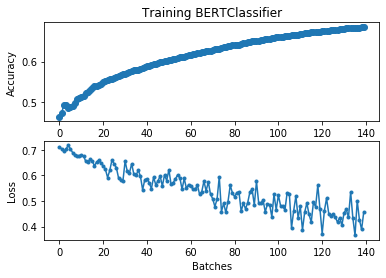

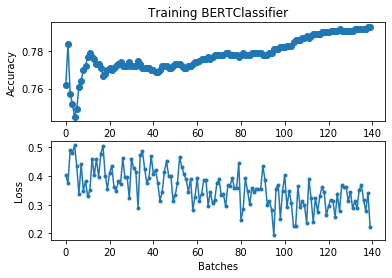

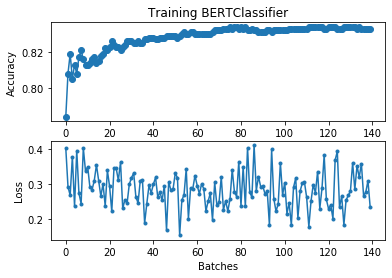

In [41]:
plot_train_stats(stats)
plot_train_stats(stats1)
plot_train_stats(stats2)

In [ ]:
model.load_parameters("data/bert.model.params", ctx=ctx)

In [42]:
data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)

In [43]:
print_infos(vocabulary, data_dev_raw, data_dev)

abortion opens the door to the sexual exploitation of women the existence of abortion gives men a little more of a safeguard against unintentionally impregnating a woman. as a result, men will be more aggressive in their sexual exploitation of women.
the fact that a child is likely to have a short life does not justify further shortening it:
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 11324  7480  1996  2341  2000  1996  4424 14427  1997  2308  1996
  4598  1997 11324  3957  2273  1037  2210  2062  1997  1037 28805  2114
  4895 18447  4765 19301  2135 17727  2890 16989  3436  1037  2450  1012
  2004  1037  2765  1010  2273  2097  2022  2062  9376  1999  2037  4424
 14427  1997  2308  1012     3  1996  2755  2008  1037  2775  2003  3497
  2000  2031  1037  2460  2166  2515  2025 16114  2582  2460  7406  2009
  1024     3     1     1     

In [44]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)

100%|██████████| 600/600 [02:59<00:00,  3.35it/s]

Time for [prediction]: 0:02:59.172701


In [45]:
metric.get()

('accuracy', 0.8265609514370664)

In [47]:
# all_labels = ["0", "1"]
y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)

In [48]:
np.unique(y_true)

array([0, 1], dtype=int32)

In [49]:
report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

Confusion Matrix:
[[8598  235]
 [3090 7248]]

Accuracy:  0.83 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.74      0.97      0.84      8833
           1       0.97      0.70      0.81     10338

    accuracy                           0.83     19171
   macro avg       0.85      0.84      0.83     19171
weighted avg       0.86      0.83      0.82     19171



{'macro': 0.83, 'micro': 0.83}

### Evaluate

In [19]:
def heatconmat(y_test, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_test.unique()))
    plt.show()


def report_training_results(y_test, y_pred, name=None, heatmap=True):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    if heatmap:
        heatconmat(y_test['is_same_side'], y_pred)
    print()
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2), '\n')  #

    print('Report{}:'.format("" if not name else " for [{}]".format(name)))
    print(classification_report(y_test, y_pred))

    f1_dic = {}
    f1_dic['macro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='macro'), 2)
    f1_dic['micro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='micro'), 2)
    return f1_dic

### Cross topic - Training and evaluating model 

In [ ]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(within_traindev_df)

In [ ]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    model.save_parameters("data/bert.model.params")
    
    plot_train_stats(stats)    

In [ ]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
with Timer("6 - evaluate"):
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])
    
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)